In [2]:
#Suponemos que excitamos a todas las NPs, de otro modo, el DOD presentaría también espectro de NPs sin excitar.
from constants import*
from functions import*
#from functionsRosei import*
#from constantsRosei import*
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from functools import partial
import pandas as pd

0.0177717228363


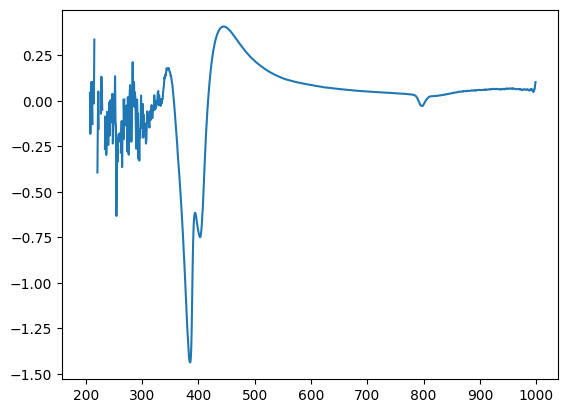

In [3]:
#I handle Inf and NaN, replacing them with np.nan as they're treated as float and not mere strings.
DODtestDF = pd.read_csv('TASavgMatrix.csv', header = None, na_values=["Inf", "-Inf", "NaN"])
DODtestDF.replace([np.inf, -np.inf], np.nan, inplace=True)
DODtestWavelength = DODtestDF.iloc[1:,0].to_numpy(dtype=float)
DODtestDelay = DODtestDF.iloc[0,1:].to_numpy(dtype=float)
DODtestSpectrum = DODtestDF.iloc[1:,1:].to_numpy(dtype=float)

testDelay = 1
delayIndex = np.searchsorted(DODtestDelay, testDelay, side="left")
fixedDelaySpectrum = DODtestSpectrum[:,delayIndex]

Figure, ax=plt.subplots()
ax.plot(DODtestWavelength, fixedDelaySpectrum)
plt.show()

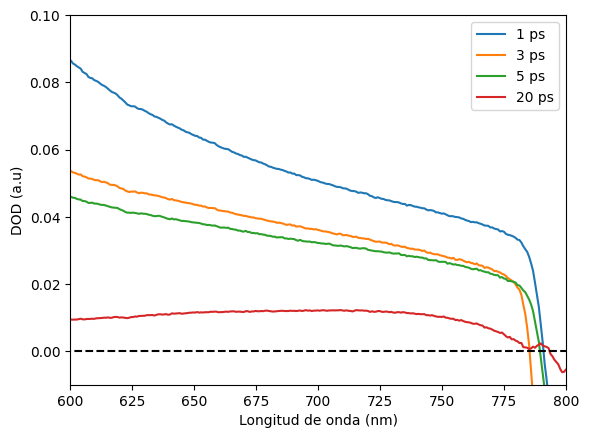

In [ ]:
testDelays = [1, 3, 5, 20]

Figure, ax=plt.subplots()

for tD in testDelays:
    delayIndex = np.searchsorted(DODtestDelay, tD, side="left")
    fixedDelaySpectrum = DODtestSpectrum[:,delayIndex]
    ax.plot(DODtestWavelength, fixedDelaySpectrum, label = '{:.4g} ps' .format(tD))
ax.hlines(0, DODtestWavelength[0], DODtestWavelength[-1], linestyles='--', color='black')
ax.set_xlim(300,800)
#ax.set_ylim(-0.01, 0.1)
ax.legend()
ax.set_xlabel('Longitud de onda (nm)')
ax.set_ylabel('DOD (a.u)')
plt.show()

# Fitting $E_{plasma}$ and $\gamma_{bulk}$

In [3]:
minWavelength = 250 #nm
maxWavelength = 900 #nm
points = 500
Tamb = 300          #K

dataWater = np.loadtxt('SegelsteinWaterDielectric.csv', delimiter=',') #x Axis is in micrometers
dataWaterWavelength = dataWater[:,0] * 1e3 #in nm
nWaterReal = dataWater[:,1]
nWaterImag = dataWater[:,2]

wavelengths = np.linspace(minWavelength, maxWavelength, points)
energies = hE*c*1e-6/wavelengths            #eV
nWaterPlot = convertToInterpolatedComplex(dataWaterWavelength, nWaterReal, dataWaterWavelength, nWaterImag, wavelengths)



dataAbsorbance = np.loadtxt('absorbance30uJafter.csv', delimiter=',')
#trimmed the data because then, the absorbance blows up. 
dataAbsWavelenght = dataAbsorbance[:680,0] 
dataAbsEnergies = hE*c*1e-6/dataAbsWavelenght
dataAbs = dataAbsorbance[:680,1]

nWater = convertToInterpolatedComplex(dataWaterWavelength, nWaterReal, dataWaterWavelength, nWaterImag, dataAbsWavelenght)
#dielWater = refractionIndexToDielectricFunc(nWater)
nWaterFixed = np.ones(len(dataAbsWavelenght))*1.33 + 1j*np.zeros(len(dataAbsWavelenght))

rNP = 10          #nm

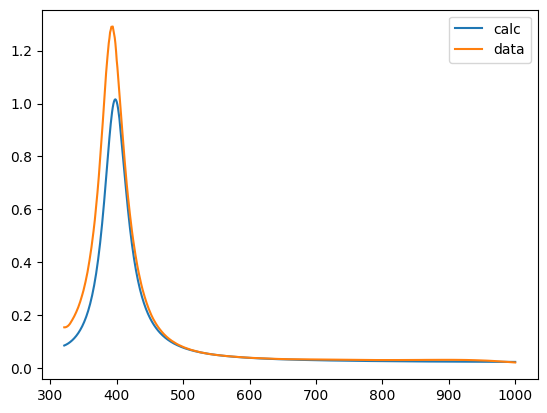

In [ ]:
nWaterTest = convertToInterpolatedComplex(dataWaterWavelength, nWaterReal, dataWaterWavelength, nWaterImag, wavelengths)

fitFunc = partial(fullAbsCoeffCoreFit, r=rNP, Eg = Eg, gammaIB = gammaIB, T=Tamb, nMedium=nWater, Ef=Ef)

#This is something to help my find initial guess by hand
asd = fitFunc(dataAbsEnergies, 75, 8.5, 0.34) + .018

Figure, ax = plt.subplots()
ax.plot(dataAbsWavelenght,asd, label = 'calc')
ax.plot(dataAbsWavelenght, dataAbs, label = 'data')
#ax.set_ylim(-0.2,2)
ax.legend()
plt.show()

In [12]:
def residuals(params):
    A, Ep, GammaBulk, y0 = params
    model = fitFunc(dataAbsEnergies, A, Ep, GammaBulk) + y0
    return model - dataAbs

Aguess = 30
EpGuess = 6.8
gammaBuGuess = 0.2
y0guess = 0.04
initialGuess = [Aguess, EpGuess, gammaBuGuess, y0guess]
fittingResults = least_squares(residuals, initialGuess)
Afit, EpFit, gammaBulkFit, y0Fit = fittingResults.x
print('A: {:.4g}, Eplasma:{:.4g}, gammaBulk:{:.4g}, y0:{:.4g}' .format(Afit, EpFit, gammaBulkFit,y0Fit))

A: 75.16, Eplasma:8.846, gammaBulk:0.3393, y0:0.01838


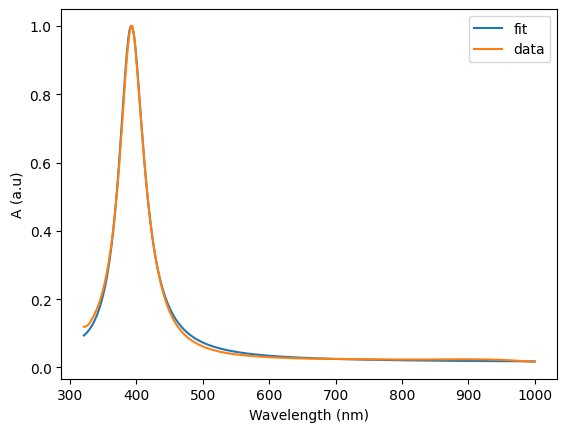

In [13]:
fittedFunction = fitFunc(dataAbsEnergies, Afit, EpFit, gammaBulkFit) + y0Fit
Figure, ax = plt.subplots()
ax.plot(dataAbsWavelenght, fittedFunction/max(fittedFunction), label='fit')
ax.plot(dataAbsWavelenght, dataAbs/max(dataAbs), label = 'data')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
plt.show()

# Plotting Some DOD's 

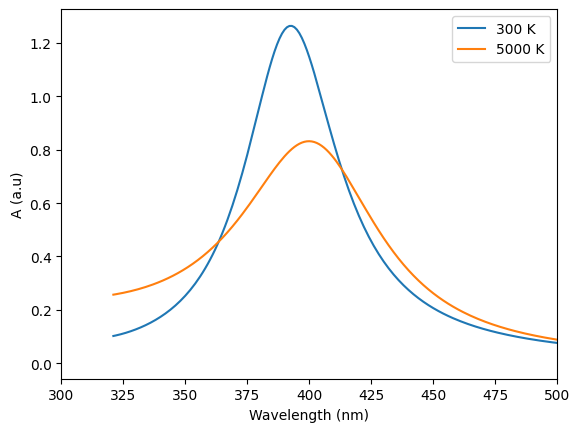

In [14]:
T = 5000
absT = fullAbsCoeffCoreFit(dataAbsEnergies, Afit, EpFit, gammaBulkFit, rNP, Eg, gammaIB, Ef, T, nWater)
absTamb = fittedFunction-y0Fit

Figure, ax = plt.subplots()
ax.plot(dataAbsWavelenght, absTamb, label='{:.4g} K' .format(Tamb))
ax.plot(dataAbsWavelenght, absT, label = '{:.4g} K' .format(T) )
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
ax.set_xlim(300,500)
plt.show()

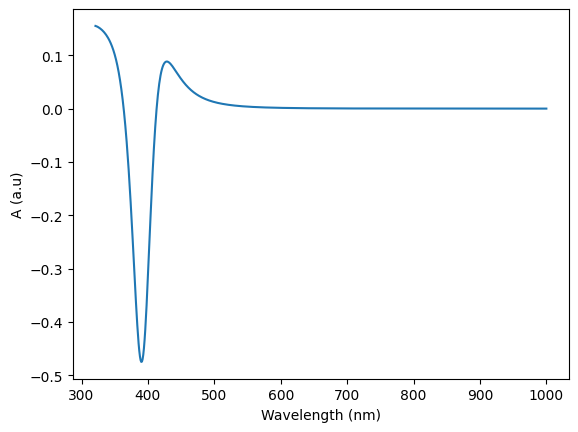

In [15]:
DOD = absT - absTamb

Figure, ax = plt.subplots()
ax.plot(dataAbsWavelenght, DOD)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
plt.show()

In [63]:
Ts = [1000, 3000, 5000, 8000]
DODs = []
absTambTemp = fullAbsCoeffCoreFit(energies, Afit, EpFit, gammaBulkFit, rNP, Eg, gammaIB, Ef, Tamb, nWaterPlot)
for T in Ts:
    absTtemp = fullAbsCoeffCoreFit(energies, Afit, EpFit, gammaBulkFit, rNP, Eg, gammaIB, Ef, T, nWaterPlot)
    DOD = absTtemp - absTambTemp
    DODs.append(DOD)

c:\Users\Usuario\Desktop\temp\Santillan\functions.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((E-Ef)/(k*T)))


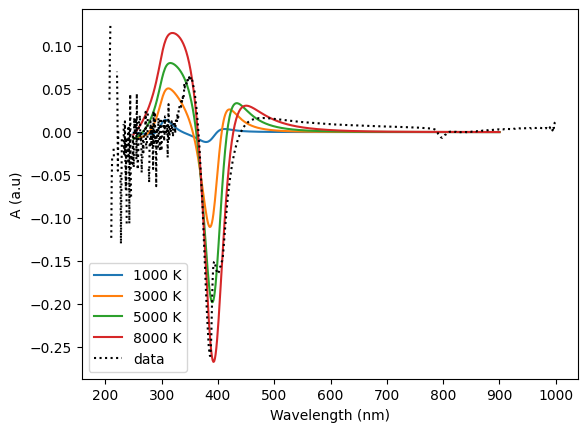

In [64]:
Figure, ax = plt.subplots()
for i,T in enumerate(Ts):
    ax.plot(wavelengths, DODs[i], label = '{:.4g} K' .format(T) )
ax.plot(DODtestWavelength, fixedDelaySpectrum*0.2, linestyle = ':', label = 'data', color = 'black')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
plt.show()

## Effect of $E_p$

In [34]:
Eps = [6, 7, 8, 9]
DODs = []
TEps = 5000

for Ep in Eps:
    absTambEps = fullAbsCoeffCoreFit(energies, Afit, Ep, gammaBulkFit, rNP, Eg, gammaIB, Ef, Tamb, nWaterPlot)
    absEps = fullAbsCoeffCoreFit(energies, Afit, Ep, gammaBulkFit, rNP, Eg, gammaIB, Ef, TEps, nWaterPlot)
    DOD = absEps - absTambEps
    DODs.append(DOD)

c:\Users\Usuario\Desktop\temp\Santillan\functions.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((E-Ef)/(k*T)))


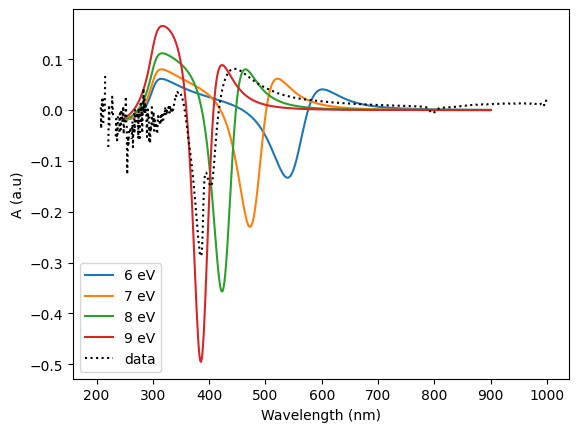

In [35]:
Figure, ax = plt.subplots()
for i,Ep in enumerate(Eps):
    ax.plot(wavelengths, DODs[i], label = '{:.4g} eV' .format(Ep) )
ax.plot(DODtestWavelength, fixedDelaySpectrum*0.2, linestyle = ':', label = 'data', color = 'black')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
#ax.set_ylim(-0.06,0.06)
ax.legend()
plt.show()

## Effect of $\gamma_{bulk}$

In [36]:
GammaBulks = [0.1, 0.2, 0.3126, 0.4]
DODs = []
TgammaBu = 5000
for GammaBulk in GammaBulks:
    absTambGammaBulk = fullAbsCoeffCoreFit(energies, Afit, EpFit, GammaBulk, rNP, Eg, gammaIB, Ef, Tamb, nWaterPlot)
    absTgammaBulk = fullAbsCoeffCoreFit(energies, Afit, EpFit, GammaBulk, rNP, Eg, gammaIB, Ef, TgammaBu, nWaterPlot)
    DOD = absTgammaBulk - absTambGammaBulk
    DODs.append(DOD)

c:\Users\Usuario\Desktop\temp\Santillan\functions.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((E-Ef)/(k*T)))


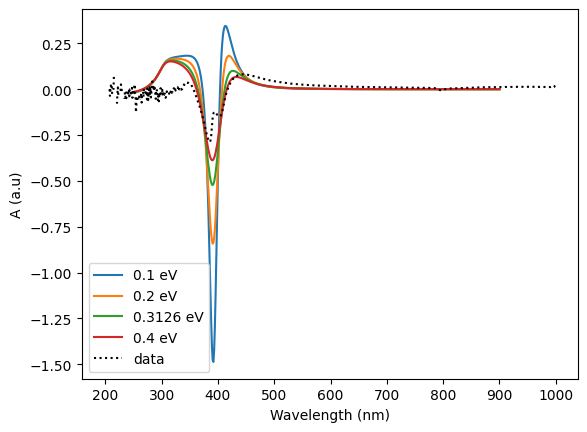

In [37]:
Figure, ax = plt.subplots()
for i,GammaBulk in enumerate(GammaBulks):
    ax.plot(wavelengths, DODs[i], label = '{:.4g} eV' .format(GammaBulk) )
ax.plot(DODtestWavelength, fixedDelaySpectrum*0.2, linestyle = ':', label = 'data', color = 'black')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
#ax.set_ylim(-0.1, 0.05)
plt.show()

## Effect of $E_{gap}$

In [43]:
Egs = [1,1.5,2,2.5]
DODs = []
TEgs = 5000
for Egap in Egs:
    absTambEgs = fullAbsCoeffCoreFit(energies, Afit, EpFit, gammaBulkFit, rNP, Egap, gammaIB, Ef, Tamb, nWaterPlot)
    absTEgs = fullAbsCoeffCoreFit(energies, Afit, EpFit, gammaBulkFit, rNP, Egap, gammaIB, Ef, TEgs, nWaterPlot)
    DOD = absTEgs - absTambEgs
    DODs.append(DOD)

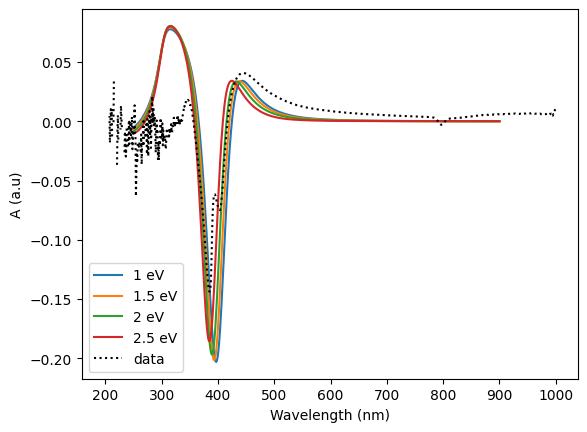

In [49]:
Figure, ax = plt.subplots()
for i,Egap in enumerate(Egs):
    ax.plot(wavelengths, DODs[i], label = '{:.4g} eV' .format(Egap) )
ax.plot(DODtestWavelength, fixedDelaySpectrum*0.1, linestyle = ':', label = 'data', color = 'black')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
plt.show()

## Effects of $\gamma_{IB}$

In [24]:
GammaIBs = [0.06, 0.09, 0.1, 0.6]
DODs = []
TgammaIB = 5000
for GammaIB in GammaIBs:
    absTambGammaIB = fullAbsCoeffCoreFit(energies, Afit, EpFit, gammaBulkFit, rNP, Eg, GammaIB, Ef, Tamb, nWaterPlot)
    absTGammaIB = fullAbsCoeffCoreFit(energies, Afit, EpFit, gammaBulkFit, rNP, Eg, GammaIB, Ef, TgammaIB, nWaterPlot)
    DOD = absTGammaIB - absTambGammaIB
    DODs.append(DOD)

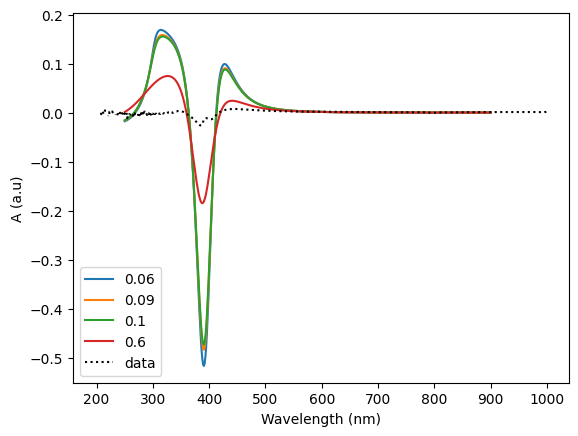

In [25]:
Figure, ax = plt.subplots()
for i,GammaIB in enumerate(GammaIBs):
    ax.plot(wavelengths, DODs[i], label = '{:.4g}' .format(GammaIB) )
ax.plot(DODtestWavelength, fixedDelaySpectrum/55, linestyle = ':', label = 'data', color = 'black')
#ax.set_ylim(-0.05,0.05)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
plt.show()

## Effect of radius

In [65]:
rs = [2, 4, 6, 8]
DODs = []
Tr = 5000
for r in rs:
    absTambGammaIB = fullAbsCoeffCoreFit(energies, Afit, EpFit, gammaBulkFit, r, Eg, gammaIB, Ef, Tamb, nWaterPlot)
    absTGammaIB = fullAbsCoeffCoreFit(energies, Afit, EpFit, gammaBulkFit, r, Eg, gammaIB, Ef, Tr, nWaterPlot)
    DOD = absTGammaIB - absTambGammaIB
    DODs.append(DOD)

c:\Users\Usuario\Desktop\temp\Santillan\functions.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((E-Ef)/(k*T)))


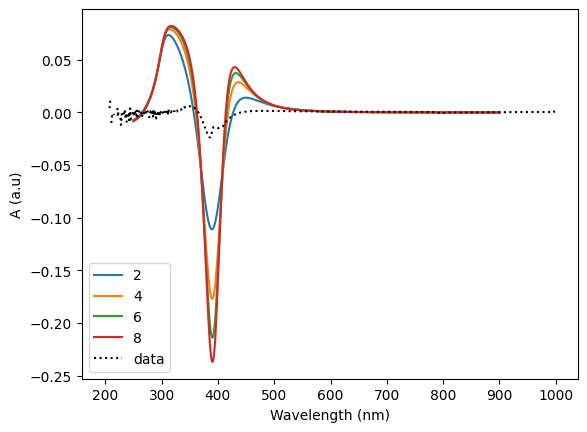

In [66]:
Figure, ax = plt.subplots()
for i,r in enumerate(rs):
    ax.plot(wavelengths, DODs[i], label = '{:.4g}' .format(r) )
ax.plot(DODtestWavelength, fixedDelaySpectrum/55, linestyle = ':', label = 'data', color = 'black')
#ax.set_ylim(-0.05,0.05)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
plt.show()

## Fitting DOD test

In [26]:
T = 10000
absT = fullAbsCoeffCoreFit(dataAbsEnergies, Afit, EpFit, gammaBulkFit, rNP, Eg, gammaIB, Ef, T, nWater)

ValueError: x and y must have same first dimension, but have shapes (680,) and (500,)

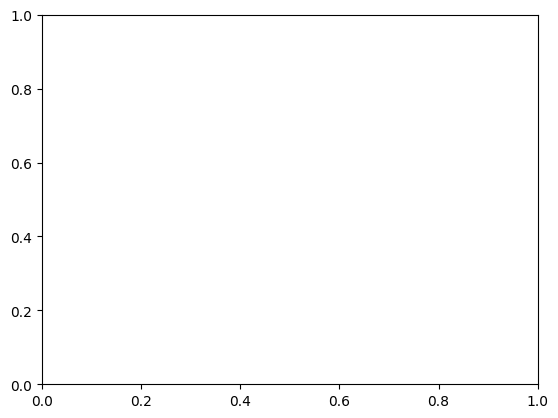

In [67]:
Figure, ax = plt.subplots()
ax.plot(dataAbsWavelenght, DOD*50,label='Fit')
ax.plot(DODtestWavelength, fixedDelaySpectrum,label='Data')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
plt.show()

In [ ]:
lowerIndex = 511
upperIndex = 759
DODtestWavelengthFit = DODtestWavelength[lowerIndex:upperIndex]
DODtestEnergiesFit = hE*c*1e-6/DODtestWavelengthFit
DODtestSpectrumFit = fixedDelaySpectrum[lowerIndex:upperIndex]
nWaterDOD = convertToInterpolatedComplex(dataWaterWavelength, nWaterReal, dataWaterWavelength, nWaterImag, DODtestWavelengthFit)

In [ ]:
absTambFit = fullAbsCoeffCoreFit(DODtestEnergiesFit, Afit, EpFit, gammaBulkFit, rNP, Eg, gammaIB, Ef, Tamb, nWaterDOD)
def residualsDOD(params):
    T,DODamplitude = params
    absT = fullAbsCoeffCoreFit(DODtestEnergiesFit, Afit, EpFit, gammaBulkFit, rNP, Eg, gammaIB, Ef, T, nWaterDOD)
    model = DODamplitude*(absT-absTambFit)
    return model-DODtestSpectrumFit

DODamplitudeGuess = 49
DODTguess = 7000
DODinitialGuess = [DODTguess, DODamplitudeGuess]
DODfittingResults = least_squares(residualsDOD, DODinitialGuess)
DODTfit, DODamplitudeFit = DODfittingResults.x
print('T:{:.4g} K , A:{:.4g}' .format(DODTfit, DODamplitudeFit))

T:7542 K , A:28.1


In [ ]:
nWaterDODfit = convertToInterpolatedComplex(dataWaterWavelength, nWaterReal, dataWaterWavelength, nWaterImag, DODtestWavelength)
absTfit = fullAbsCoeffCoreFit(dataAbsEnergies, Afit, EpFit, gammaBulkFit, rNP, Eg, gammaIB, Ef, DODTfit, nWater)
DODfit = DODamplitudeFit*(absTfit - absTamb)

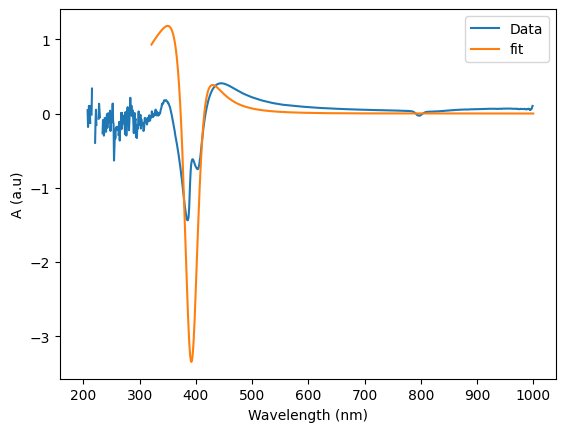

In [ ]:
Figure, ax = plt.subplots()
ax.plot(DODtestWavelength, fixedDelaySpectrum,label='Data')
ax.plot(dataAbsWavelenght, DODfit, label='fit')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
plt.show()

In [ ]:
Conc = 10/(5.56e8)
Vol = 3.14*(1e-2/2)**2 * 1e-2
Npart = Conc*Vol*6.02e23
Nphotons = 5e-6/5e-19
print(Npart)
print(Nphotons)

8499460431.654678
10000000000000.0


9.08332500522 0.0177717228363 0.098731793535 1.91


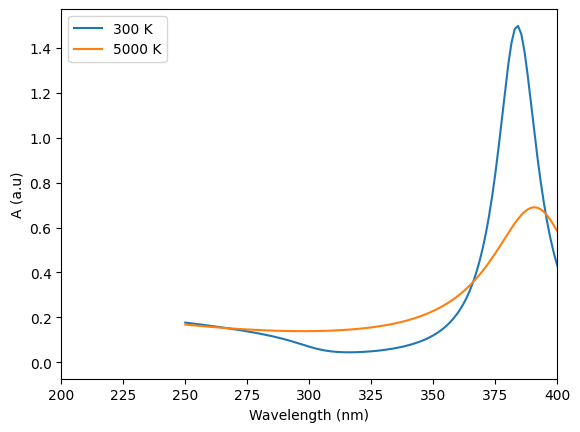

In [ ]:
T = 5000
rNP = 5
Afit=40
absT = fullAbsCoeffCoreFit(energies, Afit, Eplasma, gammaBu, rNP, Eg, gammaIB, Ef, T, nWaterTest)
absTamb = fullAbsCoeffCoreFit(energies, Afit, Eplasma, gammaBu, rNP, Eg, gammaIB, Ef, Tamb, nWaterTest)

print(Eplasma, gammaBu, gammaIB, Eg)

Figure, ax = plt.subplots()
ax.plot(wavelengths, absTamb, label='{:.4g} K' .format(Tamb))
ax.plot(wavelengths, absT, label = '{:.4g} K' .format(T) )
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
#ax.set_xlim(200,400)
plt.show()

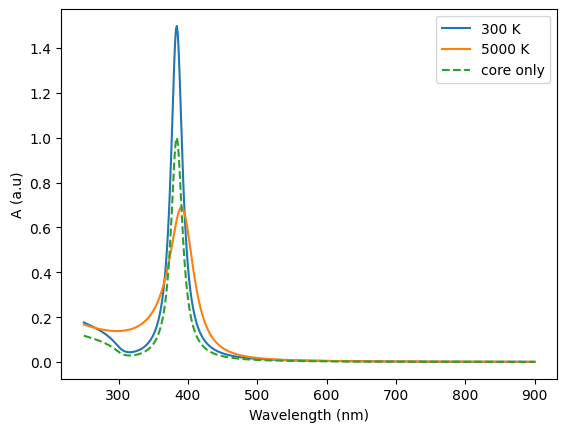

In [41]:
dielCoreIB = np.array([funcDielIBsize(E,rNP,Eg,gammaIB,Ef,Tamb) for E in energies])
dielCoreDrude = funcDrudeSize(energies, Eplasma, gammaBu, rNP, False)
dielCore = dielCoreDrude + dielCoreIB
nWater = convertToInterpolatedComplex(dataWaterWavelength, nWaterReal, dataWaterWavelength, nWaterImag, wavelengths)
extCoeffCoreOnly = funcExtCoeff(rNP, wavelengths, dielCore, nWater)  

Figure, ax = plt.subplots()
ax.plot(wavelengths, absTamb, label='{:.4g} K' .format(Tamb))
ax.plot(wavelengths, absT, label = '{:.4g} K' .format(T) )
ax.plot(wavelengths, extCoeffCoreOnly/max(extCoeffCoreOnly), label = 'core only', linestyle = '--')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('A (a.u)')
ax.legend()
#ax.set_xlim(200,400)
plt.show()
